# Guess 2/3 of the average

A large population plays a game. Each player simultaneously picks an integer from 0-100. They then compute the average. The winner is the person whose guess is closest to 2/3 of the average.

The Nash equilibrium is for everyone to guess 0 or 1. However, in practice most people guess a number much higher than that, presumably because they assume that not everyone will play perfectly rationally. This type of game can be used to "unravel" how many levels of cognitive hierarchy people are simulating when playing games.

Nagel, R. (1995). Unraveling in guessing games: An experimental study. The American economic review, 85(5), 1313-1326.

In [1]:
from memo import memo
import jax.numpy as np
import jax
from matplotlib import pyplot as plt

In [2]:
N = np.arange(100 + 1)
@memo
def player[n: N](level, beta):
    p0: thinks[ p1: chooses(n in N, wpp=player[n](level - 1, beta) if level > 0 else 1) ]
    p0: chooses(n in N, wpp=exp(beta * -abs(n - (2/3) * E[p1.n])))
    return Pr[p0.n == n]

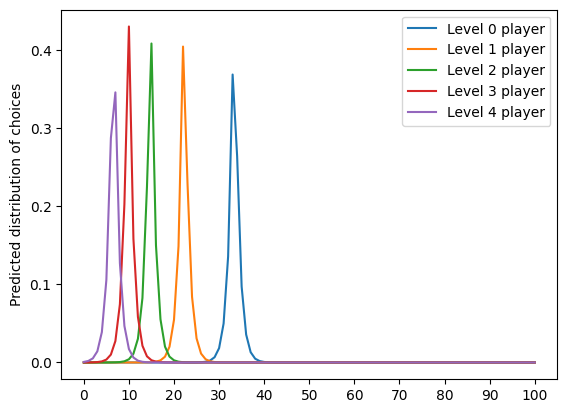

In [3]:
for level in range(5):
    plt.plot(player(level, beta=1.0), label=f'Level {level} player')
plt.xticks(N[::10])
plt.ylabel('Predicted distribution of choices')
plt.legend()

Can we fit this model to real data? Here is some data (N=61,139) [collected by the New York Times](https://www.nytimes.com/interactive/2015/08/13/upshot/are-you-smarter-than-other-new-york-times-readers.html) in 2015.

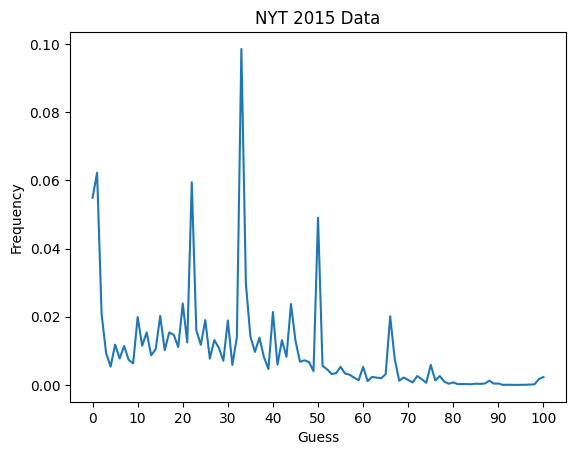

In [4]:
nyt = np.array([198.2332000732422,164.70262145996094,353.80914306640625,406.017822265625,424.3208923339844,394.8409729003906,413.4440612792969,396.7162780761719,415.16937255859375,419.8951416015625,357.85980224609375,396.4162292480469,378.4132385253906,409.1683654785156,400.7669677734375,356.4345703125,402.2672119140625,378.4882507324219,381.7137756347656,397.9914855957031,339.93182373046875,391.9154968261719,177.52975463867188,375.2626953125,395.0660095214844,361.9855041503906,413.6690979003906,388.8399658203125,398.9666748046875,416.51959228515625,362.5105895996094,421.9205017089844,384.86431884765625,-1,313.07733154296875,383.96417236328125,404.59259033203125,385.5394287109375,411.4187316894531,427.4714050292969,351.1836853027344,421.62042236328125,388.8399658203125,411.2687072753906,340.53192138671875,389.7401123046875,417.71978759765625,415.844482421875,418.16986083984375,430.3218994140625,224.93765258789062,423.1957092285156,427.7714538574219,434.14752197265625,433.09735107421875,424.4709167480469,433.54742431640625,435.1226806640625,439.0233459472656,442.6239318847656,424.6209411621094,443.6741027832031,438.0481872558594,439.0233459472656,439.8484802246094,434.44757080078125,356.8846435546875,413.5190734863281,443.1490173339844,438.8733215332031,442.1738586425781,445.3994140625,436.9229736328125,441.1236877441406,445.92449951171875,421.9205017089844,442.7739562988281,436.9229736328125,444.4242248535156,447.19970703125,445.3994140625,447.72479248046875,447.6497802734375,447.6497802734375,447.87481689453125,447.12469482421875,447.3497314453125,446.899658203125,443.0740051269531,447.0496826171875,446.899658203125,448.699951171875,448.5499267578125,448.62493896484375,448.77496337890625,448.62493896484375,448.62493896484375,448.2498779296875,448.02484130859375,440.8236389160156,438.2732238769531,397.9914855957031])[:-1]
nyt = nyt.max() - nyt
nyt = nyt / np.sum(nyt)
plt.plot(nyt)
plt.xticks(N[::10])
plt.xlabel('Guess')
plt.ylabel('Frequency')
plt.title('NYT 2015 Data')
None

In [5]:
def pred(fs, beta):
    predictions = sum([f * player(i, beta) for i, f in enumerate(np.exp(fs))])
    predictions = predictions / np.sum(predictions)
    return predictions

def loss(fs, beta):
    return np.sum(np.abs(nyt - pred(fs, beta)) ** 2)

fs = np.ones(10)
beta = np.array(1.)
for t in range(200 + 1):
    l, (dfs, dbeta) = jax.value_and_grad(loss, argnums=(0, 1))(fs, beta)
    fs = fs - dfs * 10.0
    beta = beta - dbeta * 10.0
    if t % 50 == 0:
        print(t, l)

print('Best beta =', beta)

0 0.041870005
50 0.015311688
100 0.0148307625
150 0.014520807
200 0.014317525
Best beta = 0.6579673


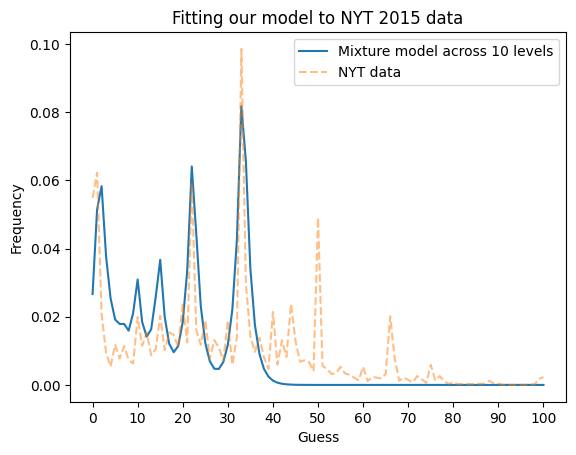

In [6]:
plt.plot(pred(fs, beta), label=f'Mixture model across {len(fs)} levels')
plt.plot(nyt, '--', label='NYT data', alpha=0.5)
plt.legend()
plt.xticks(N[::10])

plt.xlabel('Guess')
plt.ylabel('Frequency')
plt.title('Fitting our model to NYT 2015 data')
None

The model does quite well, except that it can't explain why anyone would guess 50 or 66. Presumably those people didn't understand how the game works...

Now, inspecting the fit parameters, we can work out the distribution of levels at which NYT readers are thinking.

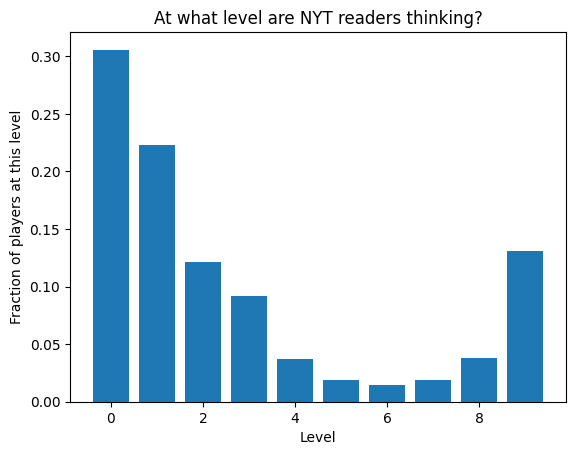

In [7]:
plt.bar(range(len(fs)), np.exp(fs) / np.sum(np.exp(fs)))
plt.ylabel('Fraction of players at this level')
plt.xlabel('Level')
plt.title('At what level are NYT readers thinking?')
None